In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

## Brusselator PDEs

#### The Brusselator PDEs for two species are
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

#### for diffusion constants $D_u$, $D_v$, and model parameters $A, B > 0$. When, the kinetic terms denotes by

<h3><center>$f(u,v) = A - (B+1)u + u^2v, \qquad g(u,v) = Bu - u^2 v,$</center></h3>

#### the fixed points of the system, are zeros of the kinetic terms and find as
<h3><center>$u^* = A, \quad v^* = \frac{B}{A}$</center></h3>

### We have already stored a numerically solved solution of the above PDEs in file for parameters $A = 4.5$ and $B = 13.29$. By loading the solution, we try to estimate these parameters as an inverse problem.

In [3]:
with open('./turing_Brusselator.npy', 'rb') as f:
    sol = np.load(f)

### Here, we randomly shuffle the order of data points at each epoch for training the neural net. 
### Also, The residuals collocations are randomly sampled from the domain.  So, they are not over the same grid as the numerically simulated data

In [9]:
torch.manual_seed(42)
np.random.seed(42)
# Diffusion constants
D_U = 0.0016
D_V = 0.0135
######################################
# Problem domain
Lx, Ly= 0.5, 0.5
Ix, Iy = 32, 32
x = torch.linspace(0, Lx, Ix).to(device)
y = torch.linspace(0, Ly, Iy).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
######################################
#  Input Data
data_X = torch.vstack([X.flatten(), Y.flatten()]).T
# To turn the tensor to a leaf node, we detach and clone it here
data_X = data_X.detach().clone()
data_X.requires_grad = True
####################################
# Species concentrations based on
# simulated values (numerically solved
# solution)
data_U = torch.from_numpy(sol[0, :, :].flatten())
data_V = torch.from_numpy(sol[1, :, :].flatten())
data_f = torch.vstack([data_U, data_V]).T.to(device)
#######################################
N = data_X.shape[0]
domain_bounds = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
#######################################
# Parameters variable
# A, B = 4.5, 13.29
A = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=f"{device.type}:{device.index}"))
sampled_As = []
B = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=f"{device.type}:{device.index}"))
sampled_Bs = []
##############################################################
# A dense neural net with 4 hidden layers, each with 64 nodes
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_dense_normalised([2, 64, 64, 64, 2], lb, ub).to(device)
optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': [A, B], 'lr': 0.1}
            ], lr=1e-4, weight_decay=0.0001)
# loss values and their corresponding regulation weights
loss_data = 0.0
lambda_data = 1
loss_physics = 0.0
lambda_physics = 1e-3
#
epochs = 20000
# Array for storing loss
losses = np.zeros((2, epochs))

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    #
    #  At each epoch, data points are 
    # randomly shuffled 
    random_indices = torch.randperm(data_X.shape[0])[:N]
    data_f_hat = model(data_X[random_indices, :]).squeeze()
    loss_data = torch.mean((data_f[random_indices, :] - data_f_hat)**2)
    #################################
    # physics derivatives
    # 
    # The residuals collocations are 
    # randomly sampled from the domain. 
    # So, they are not over the same grid
    # as the numerically simulated data     
    physics_X = torch.rand((N,2), requires_grad=True ,device=dev_str)*domain_bounds
    physics_f = model(physics_X).squeeze()
    U = physics_f[:,0]
    V = physics_f[:,1]
    
    laplacianU = Laplacian(U, physics_X)
    laplacianV = Laplacian(V, physics_X)
    #####################################
    #  Positive Parameters
    # To prevent negative values, we use
    # the exponential of parameters in the
    # residual PDEs
    FU = torch.exp(A) - (torch.exp(B) + 1) * U + U*U*V
    FV = torch.exp(B) * U - U*U*V
    
    dudt = D_U * laplacianU + FU
    dvdt = D_V * laplacianV + FV
    ################################
    # physics loss
    loss_physics = torch.mean(dudt**2 + dvdt**2)    
    ################################
    # Joint total loss
    total_loss = (
        +lambda_data*loss_data
        +lambda_physics*loss_physics        
                    )
    # Back propagate step    
    total_loss.backward(retain_graph=True)
    optimizer.step()
    # store the losses
    losses[:,i] = (loss_data.item(), loss_physics.item())
    sampled_As.append(A.item())
    sampled_Bs.append(B.item())
    
    if (i+1)%10000 == 0 or i == 0:
        print(f"Epoch: {i+1}")
        print(f"loss data: {losses[0,i]:.6f}, loss physics: {losses[1,i]:.6f}")
        print(f"A: {np.exp(sampled_As[-1]):.4f}, B: {np.exp(sampled_Bs)[-1]:.4f}")       


Epoch: 1
loss data: 17.311329, loss physics: 2.487246
A: 2.4596, B: 2.4596
Epoch: 10000
loss data: 0.197798, loss physics: 36.717476
A: 3.5548, B: 12.7795
Epoch: 20000
loss data: 0.072164, loss physics: 16.658463
A: 4.2515, B: 13.7119


## Plot loss values

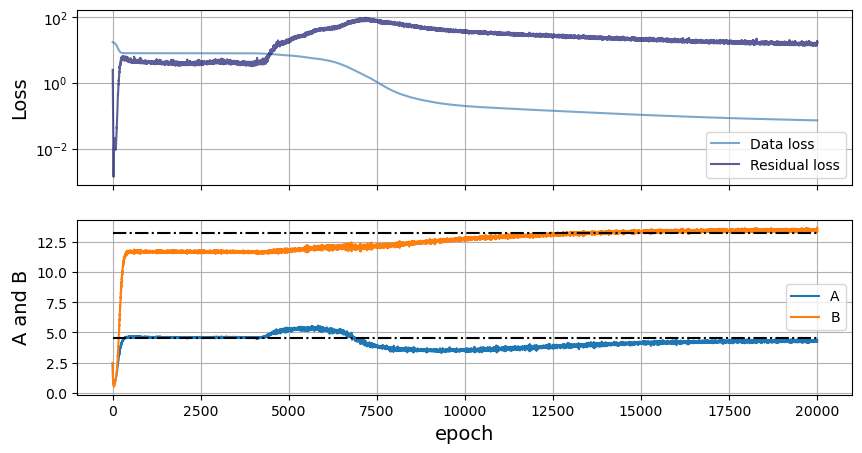

In [10]:
_ = plt.figure(figsize=(10,5))
ax=plt.subplot(211)
ax.plot(losses[0,:], alpha=.7,color='steelblue', label="Data loss")
ax.plot(losses[1,:], alpha=.7,color='midnightblue', label="Residual loss")
ax.set_xticklabels([])
ax.grid(True)
plt.grid()
ax.set_ylabel("Loss", fontsize=14)
plt.yscale('log');plt.legend();plt.grid()
ax=plt.subplot(212)
plt.plot(np.exp(sampled_As), label="A")
plt.plot(np.exp(sampled_Bs), label="B")
plt.hlines(4.5, 0,epochs, linestyles='-.', color='black')
plt.hlines(13.29, 0,epochs, linestyles='-.', color='black')
ax.set_xlabel("epoch", fontsize=14); 
ax.set_ylabel("A and B", fontsize=14)
plt.legend();plt.grid()
plt.show()

## Comparing the original parameters with their values at last step and averaged over the last 1000 epochs.
#### Note: since the parameters are included as exponentials in the residuals, we need to take their exponential before comparing to the original values.

In [19]:
print("name \t Originl \tEstimated \tAveraged Estimated")
print("-----------------------------------------------------------------------------")
print(f"A:\t 4.5 \t\t"
      f"{np.exp(sampled_As[-1]):.1f}\t\t"
      f"{np.exp(np.mean(sampled_As[-1000:])):.1f}\t\t")
print(f"A:\t 13.29 \t\t"
      f"{np.exp(sampled_Bs[-1]):.2f}\t\t"
      f"{np.exp(np.mean(sampled_Bs[-1000:])):.2f}\t\t")

name 	 Originl 	Estimated 	Averaged Estimated
-----------------------------------------------------------------------------
A:	 4.5 		4.3		4.3		
A:	 13.29 		13.71		13.49		


# Plot the trained model outputs

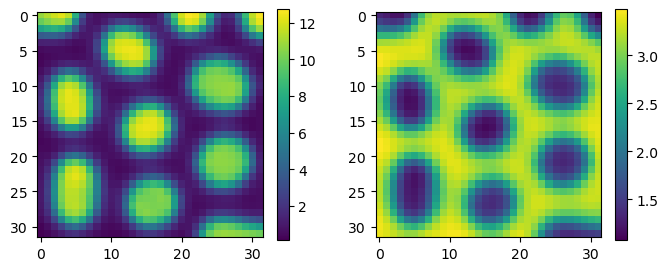

In [20]:
solution = model(data_X).cpu().detach()
U_hat = solution[:, 0].reshape((32, 32))
V_hat = solution[:, 1].reshape((32, 32))
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat)
plt.colorbar(shrink=.75)
plt.show()